# Imports

In [1]:
%load_ext autoreload

In [5]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [6]:
dim = (128, 128)

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * dim[0])

# Seed
seed = 42

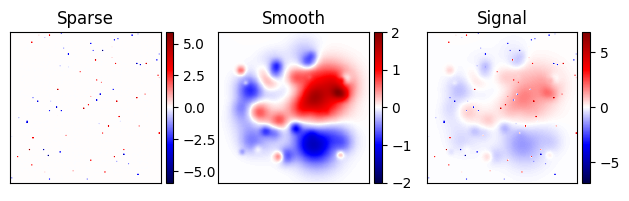

In [7]:
sparse_signal = compute_sparse(dim, sparse_range, density, seed)
smooth_signal = compute_smooth(dim, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal
plot_signal(sparse_signal, smooth_signal)

# Operator $\phi$

In [12]:
L = 0.1
theta = 0.5
op = NuFFT(dim, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

psnr = 20 # 10, 20 0.05 - 0.1  pour lambda 1
y = compute_y(y0, psnr)

# Solver

In [13]:
from pyxu.operator import Laplacian

# Loss weights
lambda1 = 0
lambda2 = 1000

coupled = True

#x1, x2 = solve(y, op, lambda1, lambda2, coupled, Laplacian(dim))

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:28:30.037904] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:29:01.863772] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.000817969424815545
INFO -- [2023-10-30 15:29:35.039029] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00023695551285124442
INFO -- [2023-10-30 15:30:08.899700] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00013201174745176476
INFO -- [2023-10-30 15:30:42.416046] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00010732404940939454
INFO -- [2023-10-30 15:31:01.949794] Iteration 2_291
	iteration: 2291
	N_iter: 2292.0
	RelError[x]: 9.998968401827645e-05
INFO -- [2023-10-30 15:31:01.950792] Stopping Criterion satisfied -> END


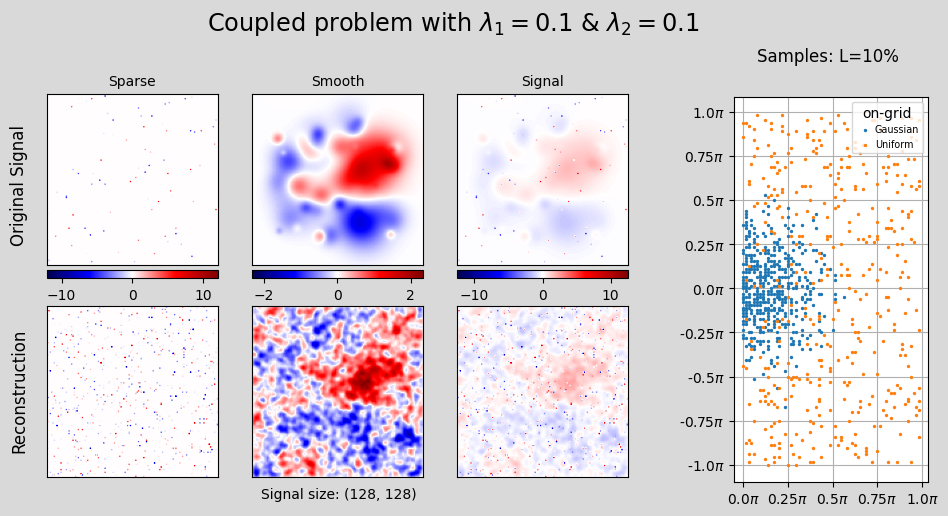

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:31:37.770912] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:32:10.795573] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0013604571867820968
INFO -- [2023-10-30 15:32:43.866111] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.0007198734063233563
INFO -- [2023-10-30 15:33:17.247817] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.000474330842188522
INFO -- [2023-10-30 15:33:50.775133] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00034083033773027227
INFO -- [2023-10-30 15:34:24.195735] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00025483178316919227
INFO -- [2023-10-30 15:34:57.663211] Iteration 3_000
	iteration: 3000
	N_iter: 3001.0
	RelError[x]: 0.00018626514213944788
INFO -- [2023-10-30 15:35:31.155620] Iteration 3_500
	iteration: 3500
	N_iter: 3501.0
	RelError[x]: 0.0001467628144738389
INFO -- [2023-10-30 15:36:05.134728] Iteration 4_000
	

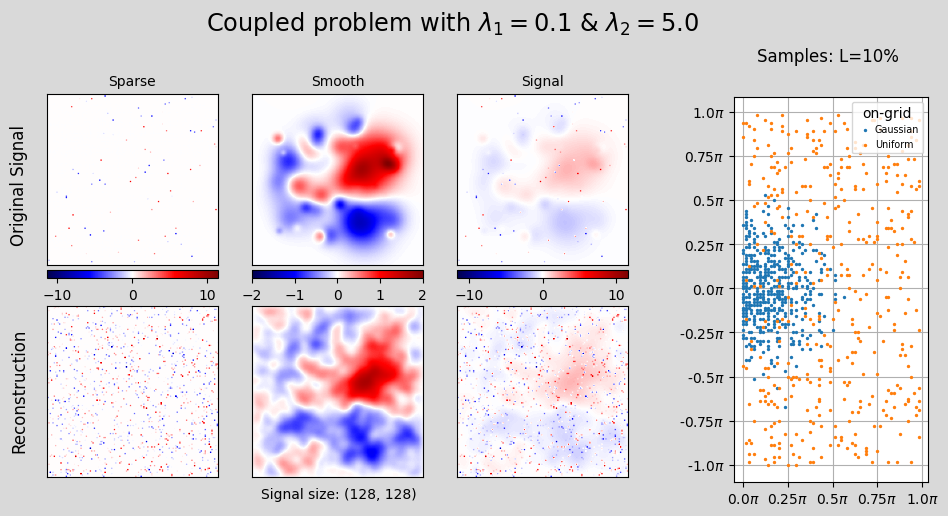

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:36:58.133047] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:37:31.319276] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0008754986142383677
INFO -- [2023-10-30 15:38:04.718934] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00031726801200021153
INFO -- [2023-10-30 15:38:38.086677] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00031720784875386457
INFO -- [2023-10-30 15:39:11.795507] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00029459339407922466
INFO -- [2023-10-30 15:39:45.559191] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00026668591566794567
INFO -- [2023-10-30 15:40:19.394683] Iteration 3_000
	iteration: 3000
	N_iter: 3001.0
	RelError[x]: 0.0002400349251929664
INFO -- [2023-10-30 15:40:53.207236] Iteration 3_500
	iteration: 3500
	N_iter: 3501.0
	RelError[x]: 0.00021341549513715662
INFO -- [2023-10-30 15:41:27.253165] Iteration 4_00

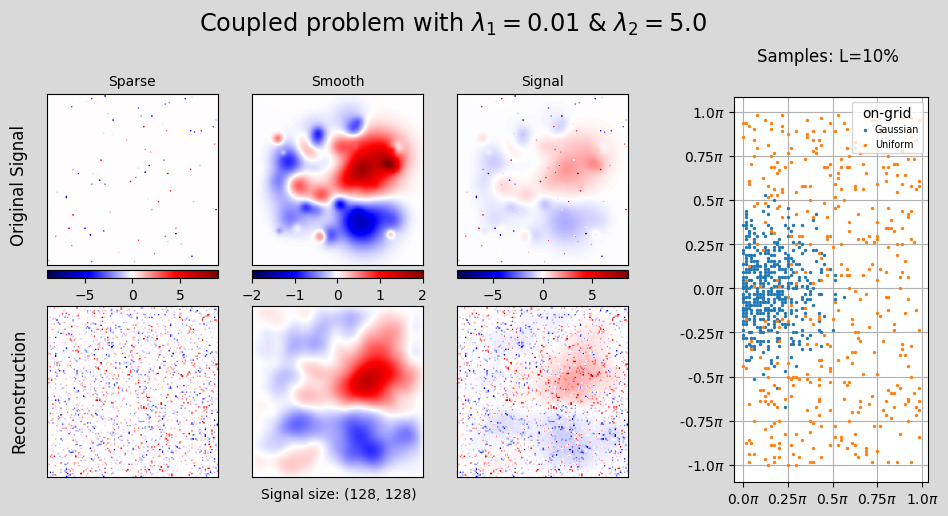

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:45:14.908578] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:45:45.617433] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0006570183975825153
INFO -- [2023-10-30 15:46:18.748809] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.0005299359763651798
INFO -- [2023-10-30 15:46:52.240221] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.000437718925422743
INFO -- [2023-10-30 15:47:25.896193] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.0003572627669017389
INFO -- [2023-10-30 15:47:59.601034] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.0002951271240734549
INFO -- [2023-10-30 15:48:33.260996] Iteration 3_000
	iteration: 3000
	N_iter: 3001.0
	RelError[x]: 0.0002433821171116968
INFO -- [2023-10-30 15:49:06.978803] Iteration 3_500
	iteration: 3500
	N_iter: 3501.0
	RelError[x]: 0.00020730088826201028
INFO -- [2023-10-30 15:49:40.676662] Iteration 4_000
	it

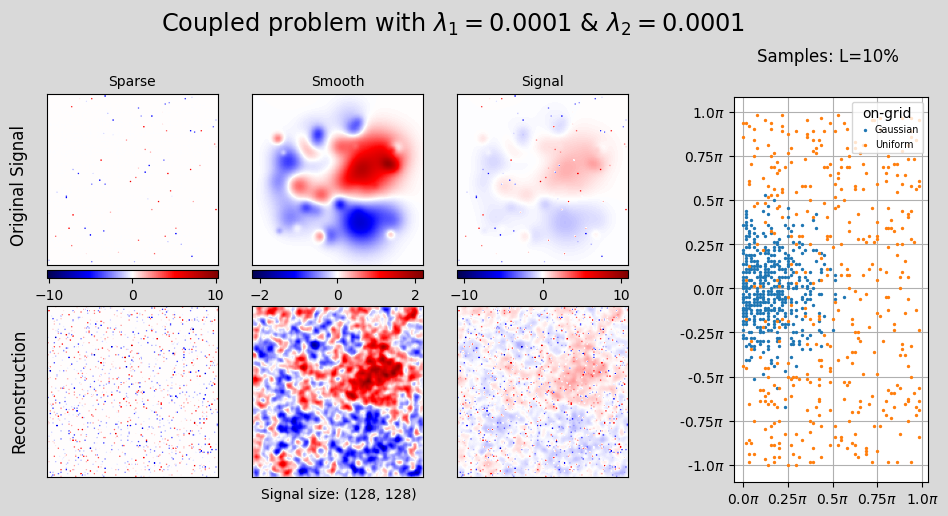

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:54:04.470043] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:54:37.158603] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0013198063057441997
INFO -- [2023-10-30 15:55:10.305935] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.0006143169374791675
INFO -- [2023-10-30 15:55:43.486180] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00035481804575822616
INFO -- [2023-10-30 15:56:16.768153] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00020600212528067063
INFO -- [2023-10-30 15:56:50.364285] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00012638476009563818
INFO -- [2023-10-30 15:57:07.499449] Iteration 2_750
	iteration: 2750
	N_iter: 2751.0
	RelError[x]: 9.976546993396401e-05
INFO -- [2023-10-30 15:57:07.500446] Stopping Criterion satisfied -> END


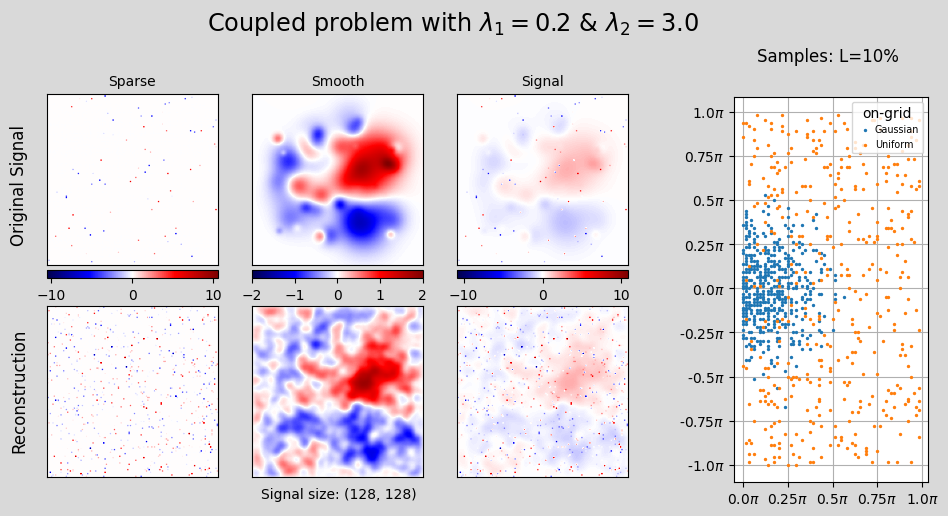

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 15:57:45.702134] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 15:58:18.566224] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0012423140687356777
INFO -- [2023-10-30 15:58:52.105508] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.000555205929327551
INFO -- [2023-10-30 15:59:25.858221] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00032244025725422704
INFO -- [2023-10-30 15:59:59.742582] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.0001912619890423788
INFO -- [2023-10-30 16:00:33.498288] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00011124898687568268
INFO -- [2023-10-30 16:00:40.604279] Iteration 2_605
	iteration: 2605
	N_iter: 2606.0
	RelError[x]: 9.995349632985995e-05
INFO -- [2023-10-30 16:00:40.605277] Stopping Criterion satisfied -> END


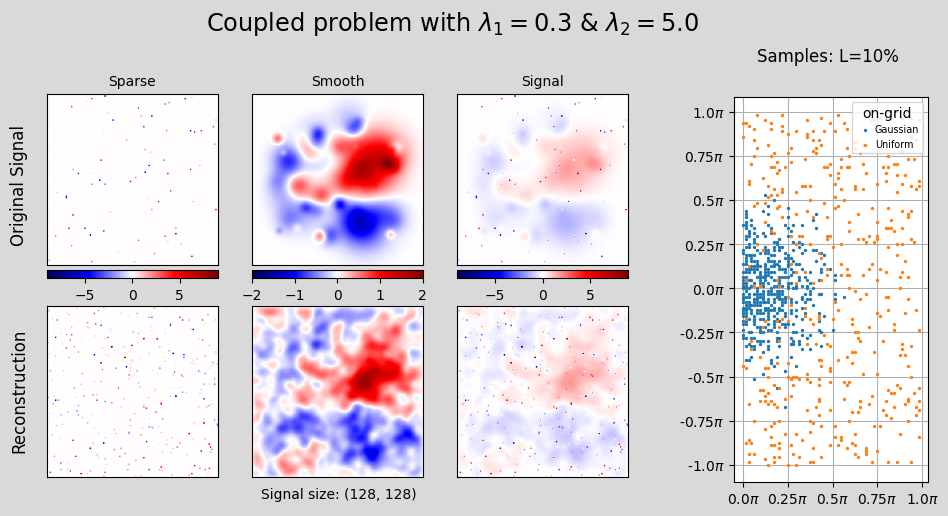

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:01:01.689049] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:01:34.344697] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0006821271060931035
INFO -- [2023-10-30 16:02:07.340435] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00020989366049954452
INFO -- [2023-10-30 16:02:40.601464] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00013995536194639233
INFO -- [2023-10-30 16:03:14.011095] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00011868649494319324
INFO -- [2023-10-30 16:03:47.372854] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00010742033110199832
INFO -- [2023-10-30 16:04:11.653903] Iteration 2_863
	iteration: 2863
	N_iter: 2864.0
	RelError[x]: 9.998051293746295e-05
INFO -- [2023-10-30 16:04:11.654901] Stopping Criterion satisfied -> END


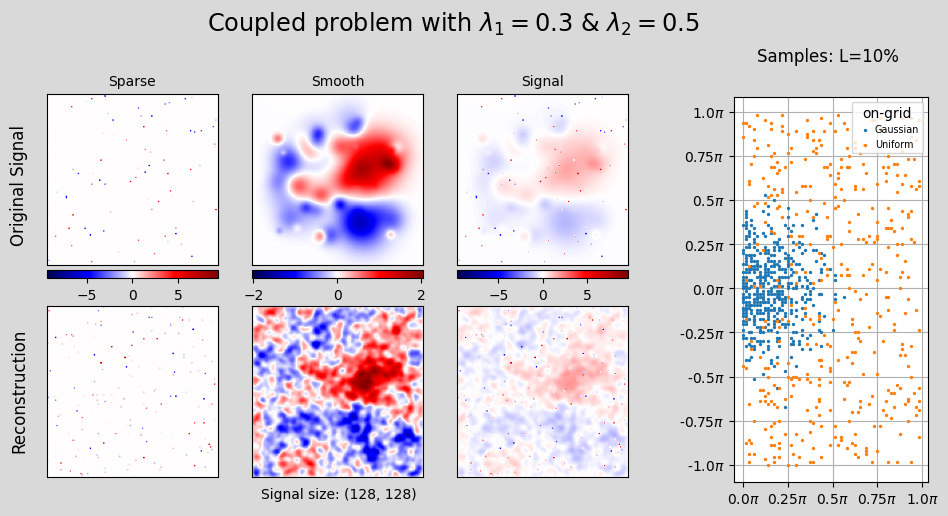

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:04:22.727804] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:04:54.782060] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0010833981316504073
INFO -- [2023-10-30 16:05:27.812705] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.0003806706117600562
INFO -- [2023-10-30 16:06:01.141552] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00017512179490137991
INFO -- [2023-10-30 16:06:34.400586] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00010764958399469632
INFO -- [2023-10-30 16:06:40.969016] Iteration 2_098
	iteration: 2098
	N_iter: 2099.0
	RelError[x]: 9.99487286901363e-05
INFO -- [2023-10-30 16:06:40.970013] Stopping Criterion satisfied -> END


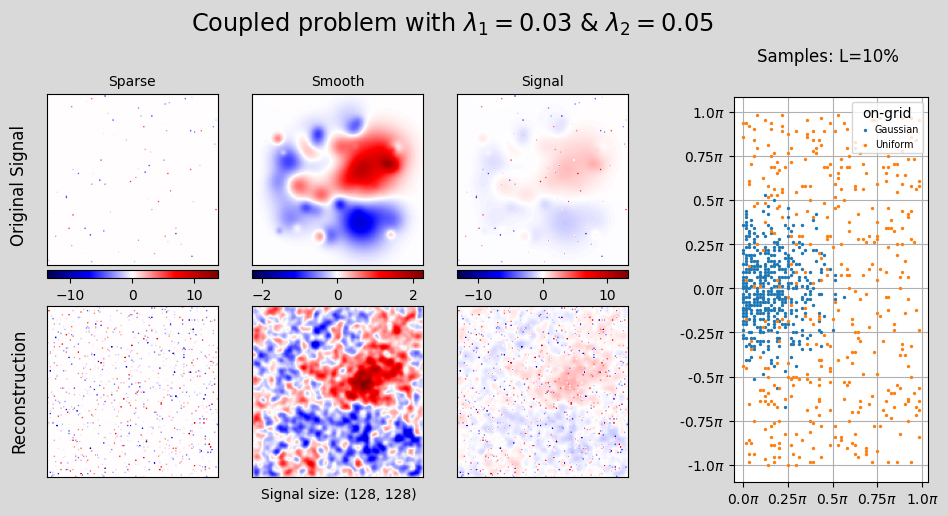

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:07:15.105674] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:07:47.873023] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0008068885881596553
INFO -- [2023-10-30 16:08:21.311576] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00043572543688976713
INFO -- [2023-10-30 16:08:55.078252] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00020086123597085761
INFO -- [2023-10-30 16:09:28.880832] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00010506227136202472
INFO -- [2023-10-30 16:09:32.538049] Iteration 2_054
	iteration: 2054
	N_iter: 2055.0
	RelError[x]: 9.994018028978733e-05
INFO -- [2023-10-30 16:09:32.539047] Stopping Criterion satisfied -> END


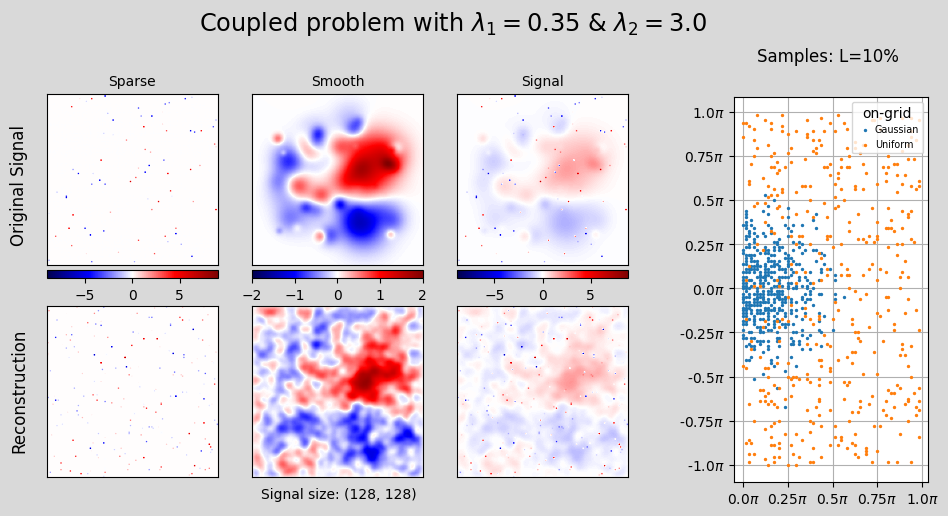

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:10:05.227864] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:10:38.740221] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.001117063089675778
INFO -- [2023-10-30 16:11:12.126913] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00048008890259036333
INFO -- [2023-10-30 16:11:45.815797] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00027989726140796595
INFO -- [2023-10-30 16:12:19.261332] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.000149900036586
INFO -- [2023-10-30 16:12:44.003149] Iteration 2_371
	iteration: 2371
	N_iter: 2372.0
	RelError[x]: 9.993255026682553e-05
INFO -- [2023-10-30 16:12:44.004146] Stopping Criterion satisfied -> END


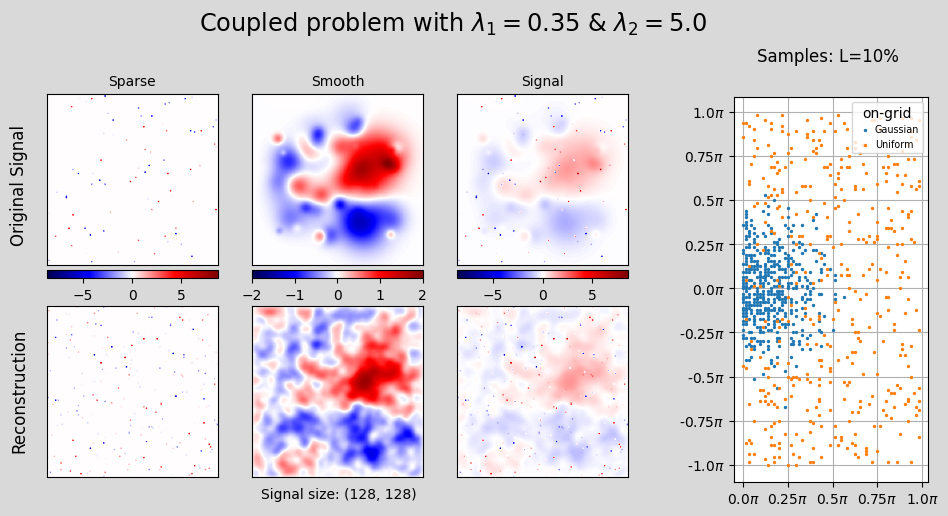

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:13:20.763816] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:13:53.849314] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.001023100241258158
INFO -- [2023-10-30 16:14:27.090396] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.0003897720759667872
INFO -- [2023-10-30 16:15:00.336464] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00023109710232144799
INFO -- [2023-10-30 16:15:33.589515] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00012643579661315033
INFO -- [2023-10-30 16:15:48.588393] Iteration 2_225
	iteration: 2225
	N_iter: 2226.0
	RelError[x]: 9.996056445465185e-05
INFO -- [2023-10-30 16:15:48.589390] Stopping Criterion satisfied -> END


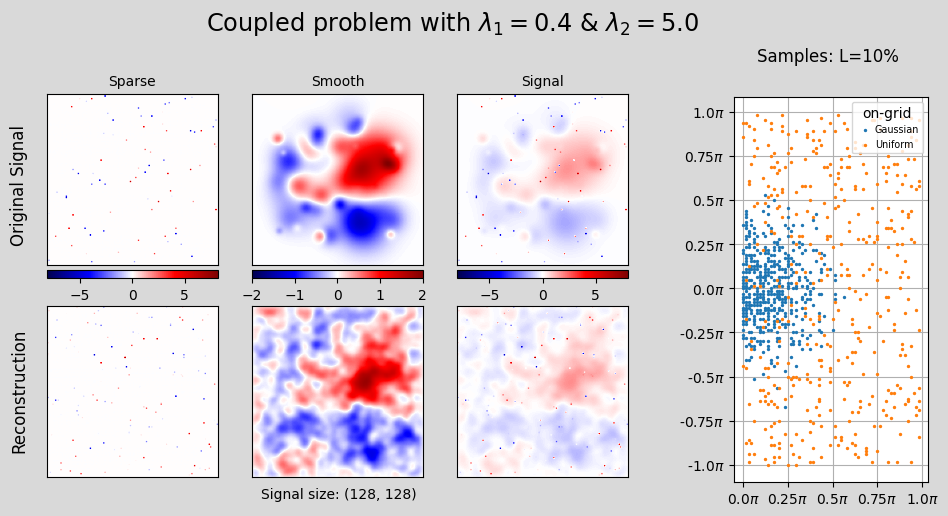

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:16:23.410117] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:16:56.638234] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0009213721894869639
INFO -- [2023-10-30 16:17:30.398925] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00022632394594080467
INFO -- [2023-10-30 16:18:04.846779] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.0001490582155635685
INFO -- [2023-10-30 16:18:38.650356] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00010002736113267892
INFO -- [2023-10-30 16:18:38.720170] Iteration 2_001
	iteration: 2001
	N_iter: 2002.0
	RelError[x]: 9.997402186185822e-05
INFO -- [2023-10-30 16:18:38.721167] Stopping Criterion satisfied -> END


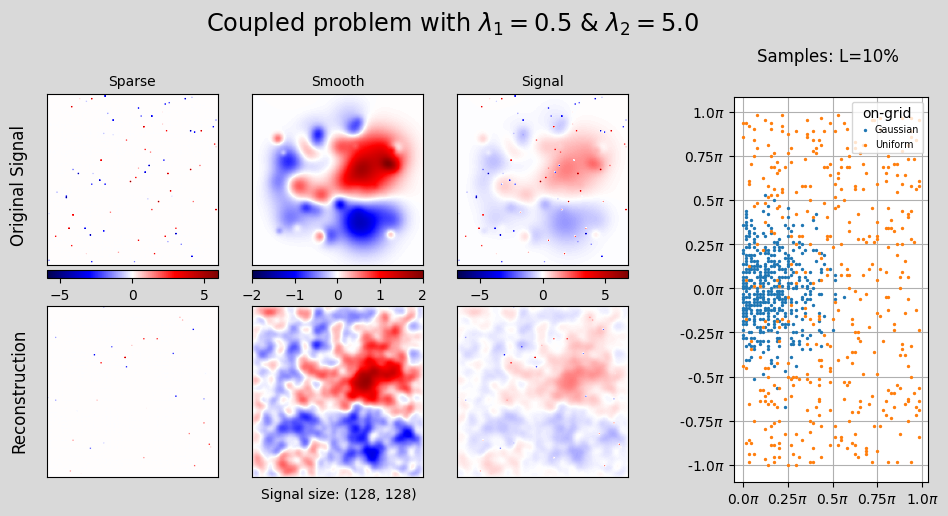

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:18:59.005906] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:19:31.951778] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0003491681704669688
INFO -- [2023-10-30 16:20:05.314534] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00023661546932944656
INFO -- [2023-10-30 16:20:38.776027] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00016918087290424113
INFO -- [2023-10-30 16:21:12.572622] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00014314382531822398
INFO -- [2023-10-30 16:21:46.255522] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00012874662549234081
INFO -- [2023-10-30 16:22:20.066081] Iteration 3_000
	iteration: 3000
	N_iter: 3001.0
	RelError[x]: 0.00011565008498468442
INFO -- [2023-10-30 16:22:53.740005] Iteration 3_500
	iteration: 3500
	N_iter: 3501.0
	RelError[x]: 0.00010217824787716623
INFO -- [2023-10-30 16:22:59.323071] Iteration 3_5

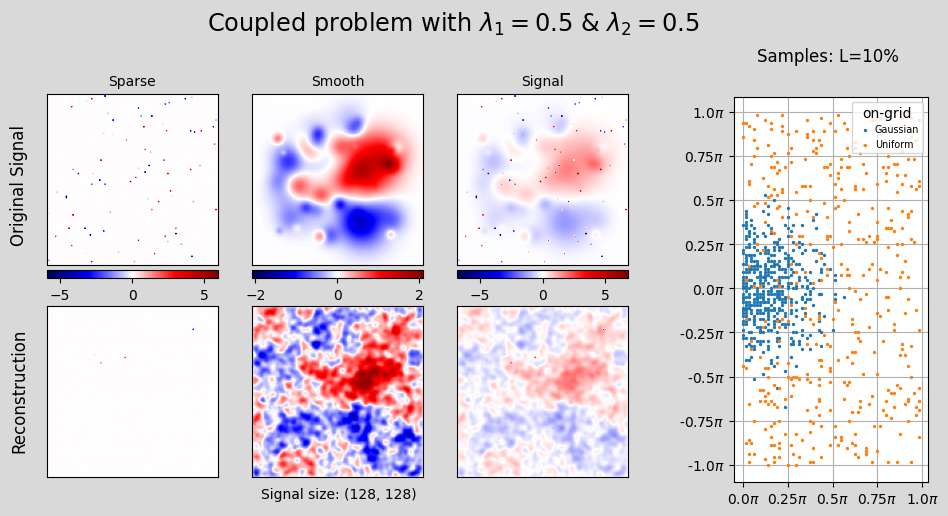

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-30 16:23:10.736896] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-10-30 16:23:42.523868] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0007565642052538862
INFO -- [2023-10-30 16:24:15.070807] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00022112404847512596
INFO -- [2023-10-30 16:24:48.137355] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.00013763478212735274
INFO -- [2023-10-30 16:25:21.883004] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00011293778049890953
INFO -- [2023-10-30 16:25:55.818229] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.00010063616767287846
INFO -- [2023-10-30 16:25:58.204845] Iteration 2_533
	iteration: 2533
	N_iter: 2534.0
	RelError[x]: 9.998468441634044e-05
INFO -- [2023-10-30 16:25:58.205842] Stopping Criterion satisfied -> END


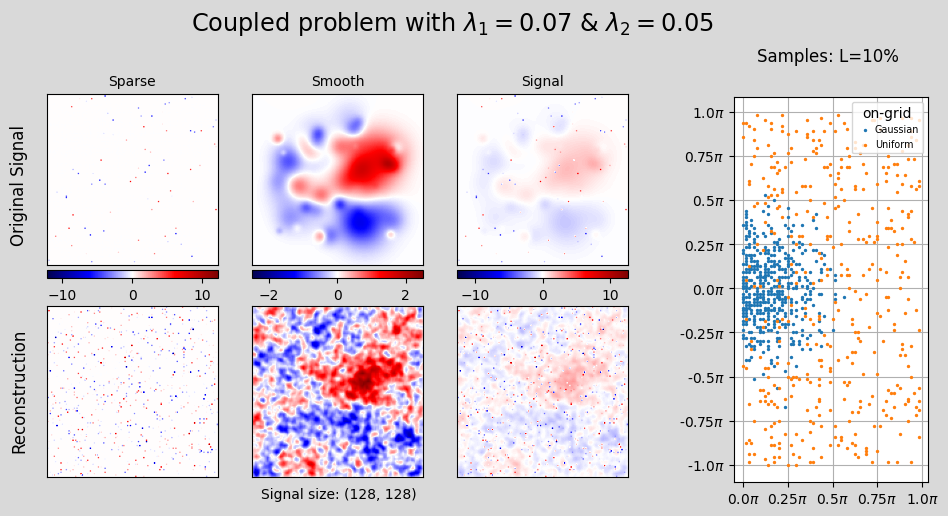

In [14]:
from os import listdir
from os.path import isfile, join

mypath = "exps/128x128/L_10%/psnr_20/coupled"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in onlyfiles:
    lambda1 = float(file[3:10])
    lambda2 = float(file[14:21])

    x1, x2 = solve(y, op, lambda1, lambda2, coupled, Laplacian(dim))

    sparse_rcstr, smooth_rcstr, signal_rcstr = map(
        lambda x: x.reshape(dim), (x1, x2, x1 + x2)
    )

    fig = plot_results(
        [sparse_signal, smooth_signal],
        [sparse_rcstr, smooth_rcstr],
        lambda1,
        lambda2,
        op,
        coupled,
    )

    save_fig(fig, lambda1, lambda2, op, psnr, coupled)

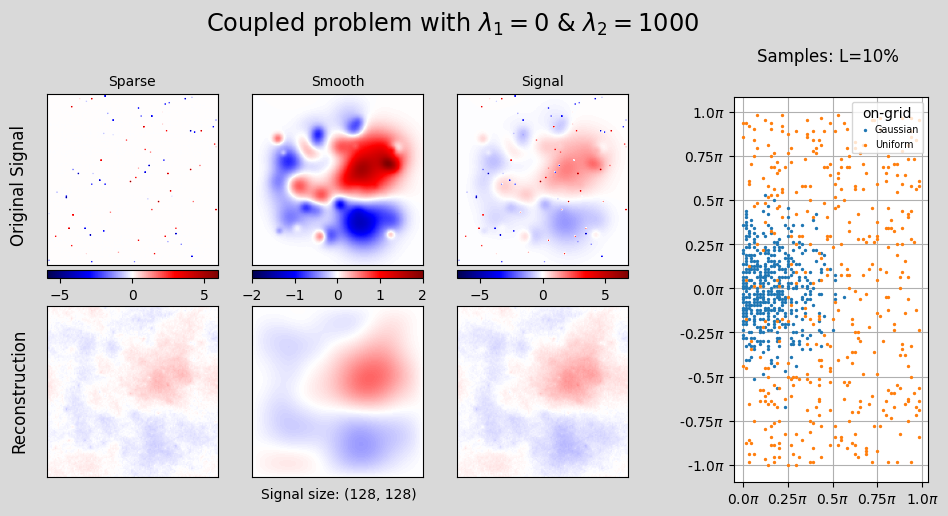

Button(description='SAVE', style=ButtonStyle())

Output()

In [12]:
sparse_rcstr, smooth_rcstr, signal_rcstr = map(
    lambda x: x.reshape(dim), (x1, x2, x1 + x2)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr, smooth_rcstr],
    lambda1,
    lambda2,
    op,
    coupled,
)

save_widget(fig, lambda1, lambda2, op, psnr)